# Problem 5 - Learning Rate, Batch Size, FashionMNIST

## 5.1

Lets initiate our parameters such as learning rates and number of epochs.

In [1]:
# import the necessary packages
import os
# initialize the list of class label names
CLASSES = ["top", "trouser", "pullover", "dress", "coat",
	"sandal", "shirt", "sneaker", "bag", "ankle boot"]
# define the minimum learning rate, maximum learning rate, batch size,
# step size, CLR method, and number of epochs
MIN_LR = 1e-10
MAX_LR = 1e1
BATCH_SIZE = 64
STEP_SIZE = 5
CLR_METHOD = "triangular"
NUM_EPOCHS = 5


Lets create a function we can use to create our model (using the code we wrote in recitation for LeNet-5):

In [2]:
from tensorflow.keras import datasets, layers, models, losses

def create_model():
  model = models.Sequential()

  model.add(layers.Conv2D(6, 5, activation='tanh', input_shape=trainX.shape[1:]))
  model.add(layers.AveragePooling2D(2))

  model.add(layers.Conv2D(16, 5, activation='tanh'))
  model.add(layers.AveragePooling2D(2))

  model.add(layers.Conv2D(120, 5, activation='tanh'))

  model.add(layers.Flatten())
  model.add(layers.Dense(84, activation='tanh'))

  model.add(layers.Dense(10, activation='softmax'))

  return model

Lets load our dataset and create test and train sets:

In [3]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import fashion_mnist
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import sys

resize_fn = lambda X, y: (tf.image.resize_with_pad(X, resize, resize) if resize else X, y)
# load the training and testing data
print("[INFO] loading Fashion MNIST data...")
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()

trainX = tf.pad(trainX, [[0, 0], [2,2], [2,2]])/255
testX = tf.pad(testX, [[0, 0], [2,2], [2,2]])/255

trainX = tf.expand_dims(trainX, axis=3, name=None)
testX = tf.expand_dims(testX, axis=3, name=None)

lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)
# construct the image generator for data augmentation
aug = ImageDataGenerator(width_shift_range=0.1,
	height_shift_range=0.1, horizontal_flip=True,
	fill_mode="nearest")

[INFO] loading Fashion MNIST data...


Lets initialize our optimizer and model:

In [4]:
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(learning_rate=MIN_LR, momentum=0.9)
model = create_model()
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


Lets create the LearningRateFinder class as shown in the given article (https://pyimagesearch.com/2019/08/05/keras-learning-rate-finder/):

In [5]:
# import the necessary packages
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import tempfile

class LearningRateFinder:
        def __init__(self, model, stopFactor=4, beta=0.98):
                # store the model, stop factor, and beta value (for computing
                # a smoothed, average loss)
                self.model = model
                self.stopFactor = stopFactor
                self.beta = beta
                # initialize our list of learning rates and losses,
                # respectively
                self.lrs = []
                self.losses = []
                # initialize our learning rate multiplier, average loss, best
                # loss found thus far, current batch number, and weights file
                self.lrMult = 1
                self.avgLoss = 0
                self.bestLoss = 1e9
                self.batchNum = 0
                self.weightsFile = None

        def reset(self):
		# re-initialize all variables from our constructor
                self.lrs = []
                self.losses = []
                self.lrMult = 1
                self.avgLoss = 0
                self.bestLoss = 1e9
                self.batchNum = 0
                self.weightsFile = None

        def is_data_iter(self, data):
                # define the set of class types we will check for
                iterClasses = ["NumpyArrayIterator", "DirectoryIterator",
                         "DataFrameIterator", "Iterator", "Sequence"]
                # return whether our data is an iterator
                return data.__class__.__name__ in iterClasses

        def on_batch_end(self, batch, logs):
                # grab the current learning rate and add log it to the list of
                # learning rates that we've tried
                lr = K.get_value(self.model.optimizer.lr)
                self.lrs.append(lr)
                # grab the loss at the end of this batch, increment the total
                # number of batches processed, compute the average average
                # loss, smooth it, and update the losses list with the
                # smoothed value
                l = logs["loss"]
                self.batchNum += 1
                self.avgLoss = (self.beta * self.avgLoss) + ((1 - self.beta) * l)
                smooth = self.avgLoss / (1 - (self.beta ** self.batchNum))
                self.losses.append(smooth)
                # compute the maximum loss stopping factor value
                stopLoss = self.stopFactor * self.bestLoss
                # check to see whether the loss has grown too large
                if self.batchNum > 1 and smooth > stopLoss:
                        # stop returning and return from the method
                        self.model.stop_training = True
                        return
                # check to see if the best loss should be updated
                if self.batchNum == 1 or smooth < self.bestLoss:
                        self.bestLoss = smooth
                # increase the learning rate
                lr *= self.lrMult
                K.set_value(self.model.optimizer.lr, lr)

        def find(self, trainData, startLR, endLR, epochs=None,
                stepsPerEpoch=None, batchSize=32, sampleSize=2048,
                verbose=1):
                # reset our class-specific variables
                self.reset()
                # determine if we are using a data generator or not
                useGen = self.is_data_iter(trainData)
                # if we're using a generator and the steps per epoch is not
                # supplied, raise an error
                if useGen and stepsPerEpoch is None:
                        msg = "Using generator without supplying stepsPerEpoch"
                        raise Exception(msg)
                # if we're not using a generator then our entire dataset must
                # already be in memory
                elif not useGen:
                        # grab the number of samples in the training data and
                        # then derive the number of steps per epoch
                        numSamples = len(trainData[0])
                        stepsPerEpoch = np.ceil(numSamples / float(batchSize))
                # if no number of training epochs are supplied, compute the
                # training epochs based on a default sample size
                if epochs is None:
                        epochs = int(np.ceil(sampleSize / float(stepsPerEpoch)))
                # compute the total number of batch updates that will take
                # place while we are attempting to find a good starting
                # learning rate
                numBatchUpdates = epochs * stepsPerEpoch
                # derive the learning rate multiplier based on the ending
                # learning rate, starting learning rate, and total number of
                # batch updates
                self.lrMult = (endLR / startLR) ** (1.0 / numBatchUpdates)
                # create a temporary file path for the model weights and
                # then save the weights (so we can reset the weights when we
                # are done)
                self.weightsFile = tempfile.mkstemp()[1]
                self.model.save_weights(self.weightsFile)
                # grab the *original* learning rate (so we can reset it
                # later), and then set the *starting* learning rate
                origLR = K.get_value(self.model.optimizer.lr)
                K.set_value(self.model.optimizer.lr, startLR)
                # construct a callback that will be called at the end of each
                # batch, enabling us to increase our learning rate as training
                # progresses
                callback = LambdaCallback(on_batch_end=lambda batch, logs:
                        self.on_batch_end(batch, logs))
                # check to see if we are using a data iterator
                if useGen:
                        self.model.fit(
                                x=trainData,
                                steps_per_epoch=stepsPerEpoch,
                                epochs=epochs,
                                verbose=verbose,
                                callbacks=[callback])
                # otherwise, our entire training data is already in memory
                else:
                        # train our model using Keras' fit method
                        self.model.fit(
                                x=trainData[0], y=trainData[1],
                                batch_size=batchSize,
                                epochs=epochs,
                                callbacks=[callback],
                                verbose=verbose)
                # restore the original model weights and learning rate
                self.model.load_weights(self.weightsFile)
                K.set_value(self.model.optimizer.lr, origLR)

        def plot_loss(self, skipBegin=10, skipEnd=10, title=""):
                # grab the learning rate and losses values to plot
                lrs = self.lrs[skipBegin:-skipEnd]
                losses = self.losses[skipBegin:-skipEnd]
                # plot the learning rate vs. loss
                plt.plot(lrs, losses)
                plt.xscale("log")
                plt.xlabel("Learning Rate (Log Scale)")
                plt.ylabel("Loss")
                # if the title is not empty, add it to the plot
                if title != "":
                        plt.title(title)

Lets initialize our LearningRateFinder and train it with our given learning rates:

[INFO] finding learning rate...
Epoch 1/5
938/938 [==============================] - 46s 49ms/step - loss: 2.3429 - accuracy: 0.0993
Epoch 2/5
938/938 [==============================] - 46s 49ms/step - loss: 2.3421 - accuracy: 0.0992
Epoch 3/5
938/938 [==============================] - 46s 49ms/step - loss: 2.3013 - accuracy: 0.1188
Epoch 4/5
938/938 [==============================] - 46s 49ms/step - loss: 1.2062 - accuracy: 0.5813
Epoch 5/5
938/938 [==============================] - 25s 26ms/step - loss: 7.7327 - accuracy: 0.5329
[INFO] learning rate finder complete
[INFO] examine plot and adjust learning rates before training


SystemExit: ignored

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


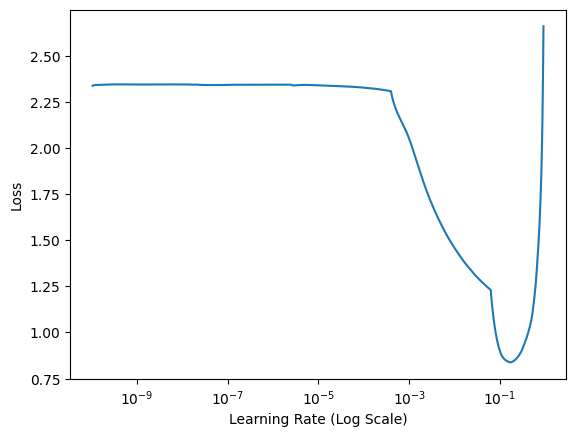

In [6]:
# initialize the learning rate finder and then train with learning
# rates ranging from 1e-10 to 1e+1
print("[INFO] finding learning rate...")
lrf = LearningRateFinder(model)
lrf.find(
	aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
	1e-10, 1e+1,
	stepsPerEpoch=np.ceil((len(trainX) / float(BATCH_SIZE))), epochs=NUM_EPOCHS,
	batchSize=BATCH_SIZE)
# plot the loss for the various learning rates and save the
# resulting plot to disk
lrf.plot_loss()

plt.savefig("learn_rate_finder.png")
# gracefully exit the script so we can adjust our learning rates
# in the config and then train the network for our full set of
# epochs
print("[INFO] learning rate finder complete")
print("[INFO] examine plot and adjust learning rates before training")
sys.exit(0)


**Answer:**

From this graph we can see that the loss is constant when learning rate (on log scale) is lower than $10^{-4}$ and then at $10^{-4}$ it starts dropping until it reaches its minimum at the learning rate of about $10^{-1}$. After this point the loss goes significantly up.

Based on this plot and the Figure 2 explanation from the article, we can pinpoint our $lr_min = 10e^{-3}$ as this is when our loss is falling and our $lr_max = 10e^{-2}$.

## 5.2

Lets create our CyclicLR class as used in the artice (https://pyimagesearch.com/2019/08/05/keras-learning-rate-finder/):

In [7]:
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
import numpy as np

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each
        cycle iteration.
    For more detail, please see paper.

    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```

    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.

    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):

        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        K.set_value(self.model.optimizer.lr, self.clr())

Lets run our train our model again with the cyclic learning rate:

In [8]:
MIN_LR = 1e-3
MAX_LR = 1e-2

# otherwise, we have already defined a learning rate space to train
# over, so compute the step size and initialize the cyclic learning
# rate method
stepSize =STEP_SIZE * (trainX.shape[0] // BATCH_SIZE)
clr = CyclicLR(
	mode='triangular',
	base_lr=MIN_LR,
	max_lr=MAX_LR,
	step_size=stepSize)

# train the network
print("[INFO] training network...")
print("[INFO] training network...")
H = model.fit(
	x=aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
	validation_data=(testX, testY),
	steps_per_epoch=trainX.shape[0] // BATCH_SIZE,
	epochs=NUM_EPOCHS,
	callbacks=[clr],
	verbose=1)
# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model.predict(x=testX, batch_size=BATCH_SIZE)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=CLASSES))

[INFO] training network...
[INFO] training network...
Epoch 1/5
937/937 [==============================] - 65s 69ms/step - loss: 2.1456 - accuracy: 0.3097 - val_loss: 1.2521 - val_accuracy: 0.5571
Epoch 2/5
937/937 [==============================] - 51s 54ms/step - loss: 1.0789 - accuracy: 0.6106 - val_loss: 0.8554 - val_accuracy: 0.6977
Epoch 3/5
937/937 [==============================] - 50s 54ms/step - loss: 0.8911 - accuracy: 0.6706 - val_loss: 0.8318 - val_accuracy: 0.7160
Epoch 4/5
937/937 [==============================] - 51s 54ms/step - loss: 0.8025 - accuracy: 0.6988 - val_loss: 0.7062 - val_accuracy: 0.7314
Epoch 5/5
937/937 [==============================] - 48s 51ms/step - loss: 0.7602 - accuracy: 0.7145 - val_loss: 0.6759 - val_accuracy: 0.7418
[INFO] evaluating network...
157/157 [==============================] - 2s 11ms/step
              precision    recall  f1-score   support

         top       0.72      0.80      0.76      1000
     trouser       0.95      0.95    

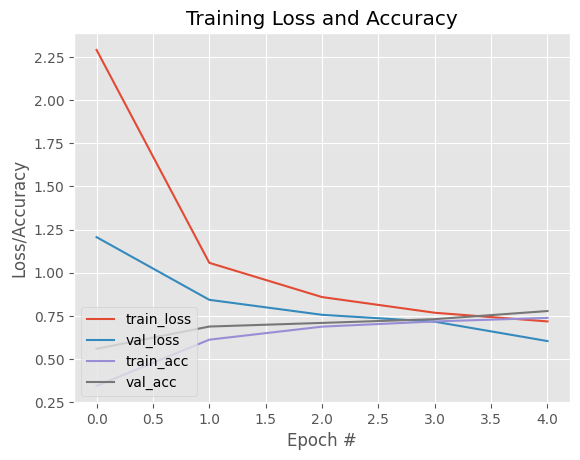

In [37]:
# construct a plot that plots and saves the training history
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('training_plot.png')

**Answer:**

From this we can see that increasing the number of epochs decreases both our training and validation loss as expected and increases out training and validation accuracy. However, we can notice that our accuracy does not go much over 0.74 (or 74%) which indicates our model is not doing as well as we might want it to. Further, our loss decreases but even at the last epoch it is not very low.

## 5.3

In [9]:
batch = 32

print("[INFO] compiling model...")
opt = SGD(learning_rate=MAX_LR, momentum=0.9)
model = create_model()
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

loss = []
batches = []

while batch <=4096:
    print("[INFO] training network...")
    H_b = model.fit(
	x=aug.flow(trainX, trainY, batch_size=batch),
	validation_data=(testX, testY),
	steps_per_epoch=trainX.shape[0] // batch,
	epochs=5,
	# callbacks=[clr],
	verbose=1)
    # evaluate the network and show a classification report
    print("[INFO] evaluating network...")
    predictions = model.predict(x=testX, batch_size=batch)
    print(classification_report(testY.argmax(axis=1),
        predictions.argmax(axis=1), target_names=CLASSES))

    loss.append(H_b.history["loss"][-1])
    batches.append(batch)

    # updating the batch size
    batch*=2


[INFO] compiling model...
[INFO] training network...
Epoch 1/5
1875/1875 [==============================] - 69s 37ms/step - loss: 0.7687 - accuracy: 0.7072 - val_loss: 0.5525 - val_accuracy: 0.7867
Epoch 2/5
1875/1875 [==============================] - 53s 28ms/step - loss: 0.5422 - accuracy: 0.7959 - val_loss: 0.4894 - val_accuracy: 0.8112
Epoch 3/5
1875/1875 [==============================] - 52s 28ms/step - loss: 0.4710 - accuracy: 0.8232 - val_loss: 0.3980 - val_accuracy: 0.8502
Epoch 4/5
1875/1875 [==============================] - 53s 28ms/step - loss: 0.4322 - accuracy: 0.8386 - val_loss: 0.4387 - val_accuracy: 0.8395
Epoch 5/5
1875/1875 [==============================] - 52s 28ms/step - loss: 0.4112 - accuracy: 0.8464 - val_loss: 0.3695 - val_accuracy: 0.8604
[INFO] evaluating network...
313/313 [==============================] - 2s 7ms/step
              precision    recall  f1-score   support

         top       0.74      0.87      0.80      1000
     trouser       0.99      

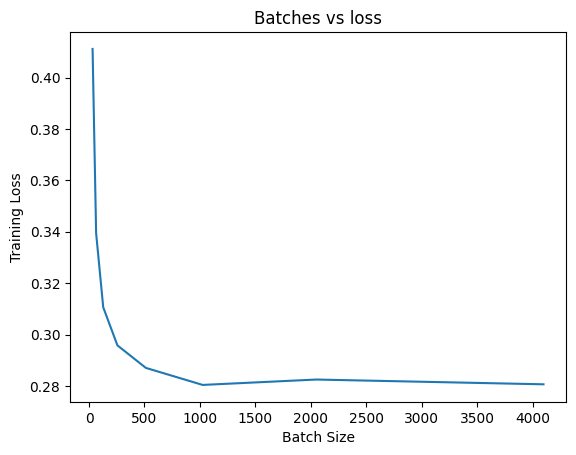

In [10]:
plt.figure()
plt.plot(batches, loss)
plt.title("Batches vs loss")
plt.xlabel("Batch Size")
plt.ylabel("Training Loss")
plt.savefig("batches_loss.png")

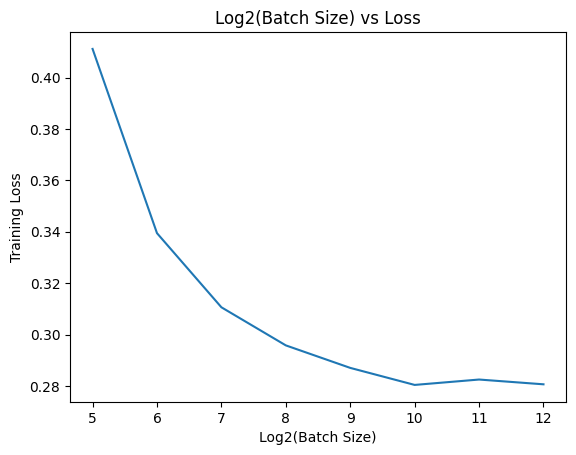

In [11]:
plt.figure()
plt.plot(np.log2(batches), loss)
plt.title("Log2(Batch Size) vs Loss")
plt.xlabel("Log2(Batch Size)")
plt.ylabel("Training Loss")
plt.savefig("log2_batches_loss.png")

**Answer:**


Looking at these 2 graphs we can see that increasing the batch size decreases the training loss. We can also see that the amount the loss decreases is less and less as we increase the batch size. Looking at the accuracy from the classification reporst we can also notice that the accuracy improves (as expected) when we increase the batch size. However, it is worth noting that at some point (approx. when batch size > 1000) increasing the batch size might not be worth the training time as the loss decreases very little at that point. Further, when it finished our model achieved accuracy of 0.89 compared to the accuracy of the cyclical model which was 0.74 (validation accuracy). Due to this we can conclude that our new model preforms much better and since these were validation accuracies that we mentioned we can also conclude that the new model would also generalize better that the cyclical one.

Finally, we need to take into consideration that our new model runs significantly longer than the cyclical one - approx. 45 minutes vs. approx. 5 minutes for the cyclical one. This kinda of high usage might become very costly and time consuming. In our case this tradeoff of time might be worth it since our accuracy increased by 0.15. However it might be worth to use lower batch size (such as 1000 or 1500) as that will most likely not decrese the accuracy by much (it will still be higher than the one of cyclical) but it will lead to much lower run time.